# Global Supply Chain: Optimizing for Costs Under Known Constraints

<img src="container carrier.jpg" width=700 height=300 />
Imports from Asia account for up to 70 percent of total U.S. imports. Global supply chains are clogged up amind booming consumer demand. And retailers struggle to keep shelves filled in the U.S. A shortage of shipping containers (critical components of modern supply chains) contributes to the disruptions.

In this project, I design a linear programming (LP) algorithm to automate and streamline decision-making for a supply chain system for a major US retailer that uses the services of five carriers. These carriers can ship containers across 290 Asia-U.S. routes. The retailer would like to have an interactive computer program that can be run to determine which carrier should supply which route to minimize the costs of the whole operation. To develop the algorithm, I use PuLP, a linear programming modeler written in Python.

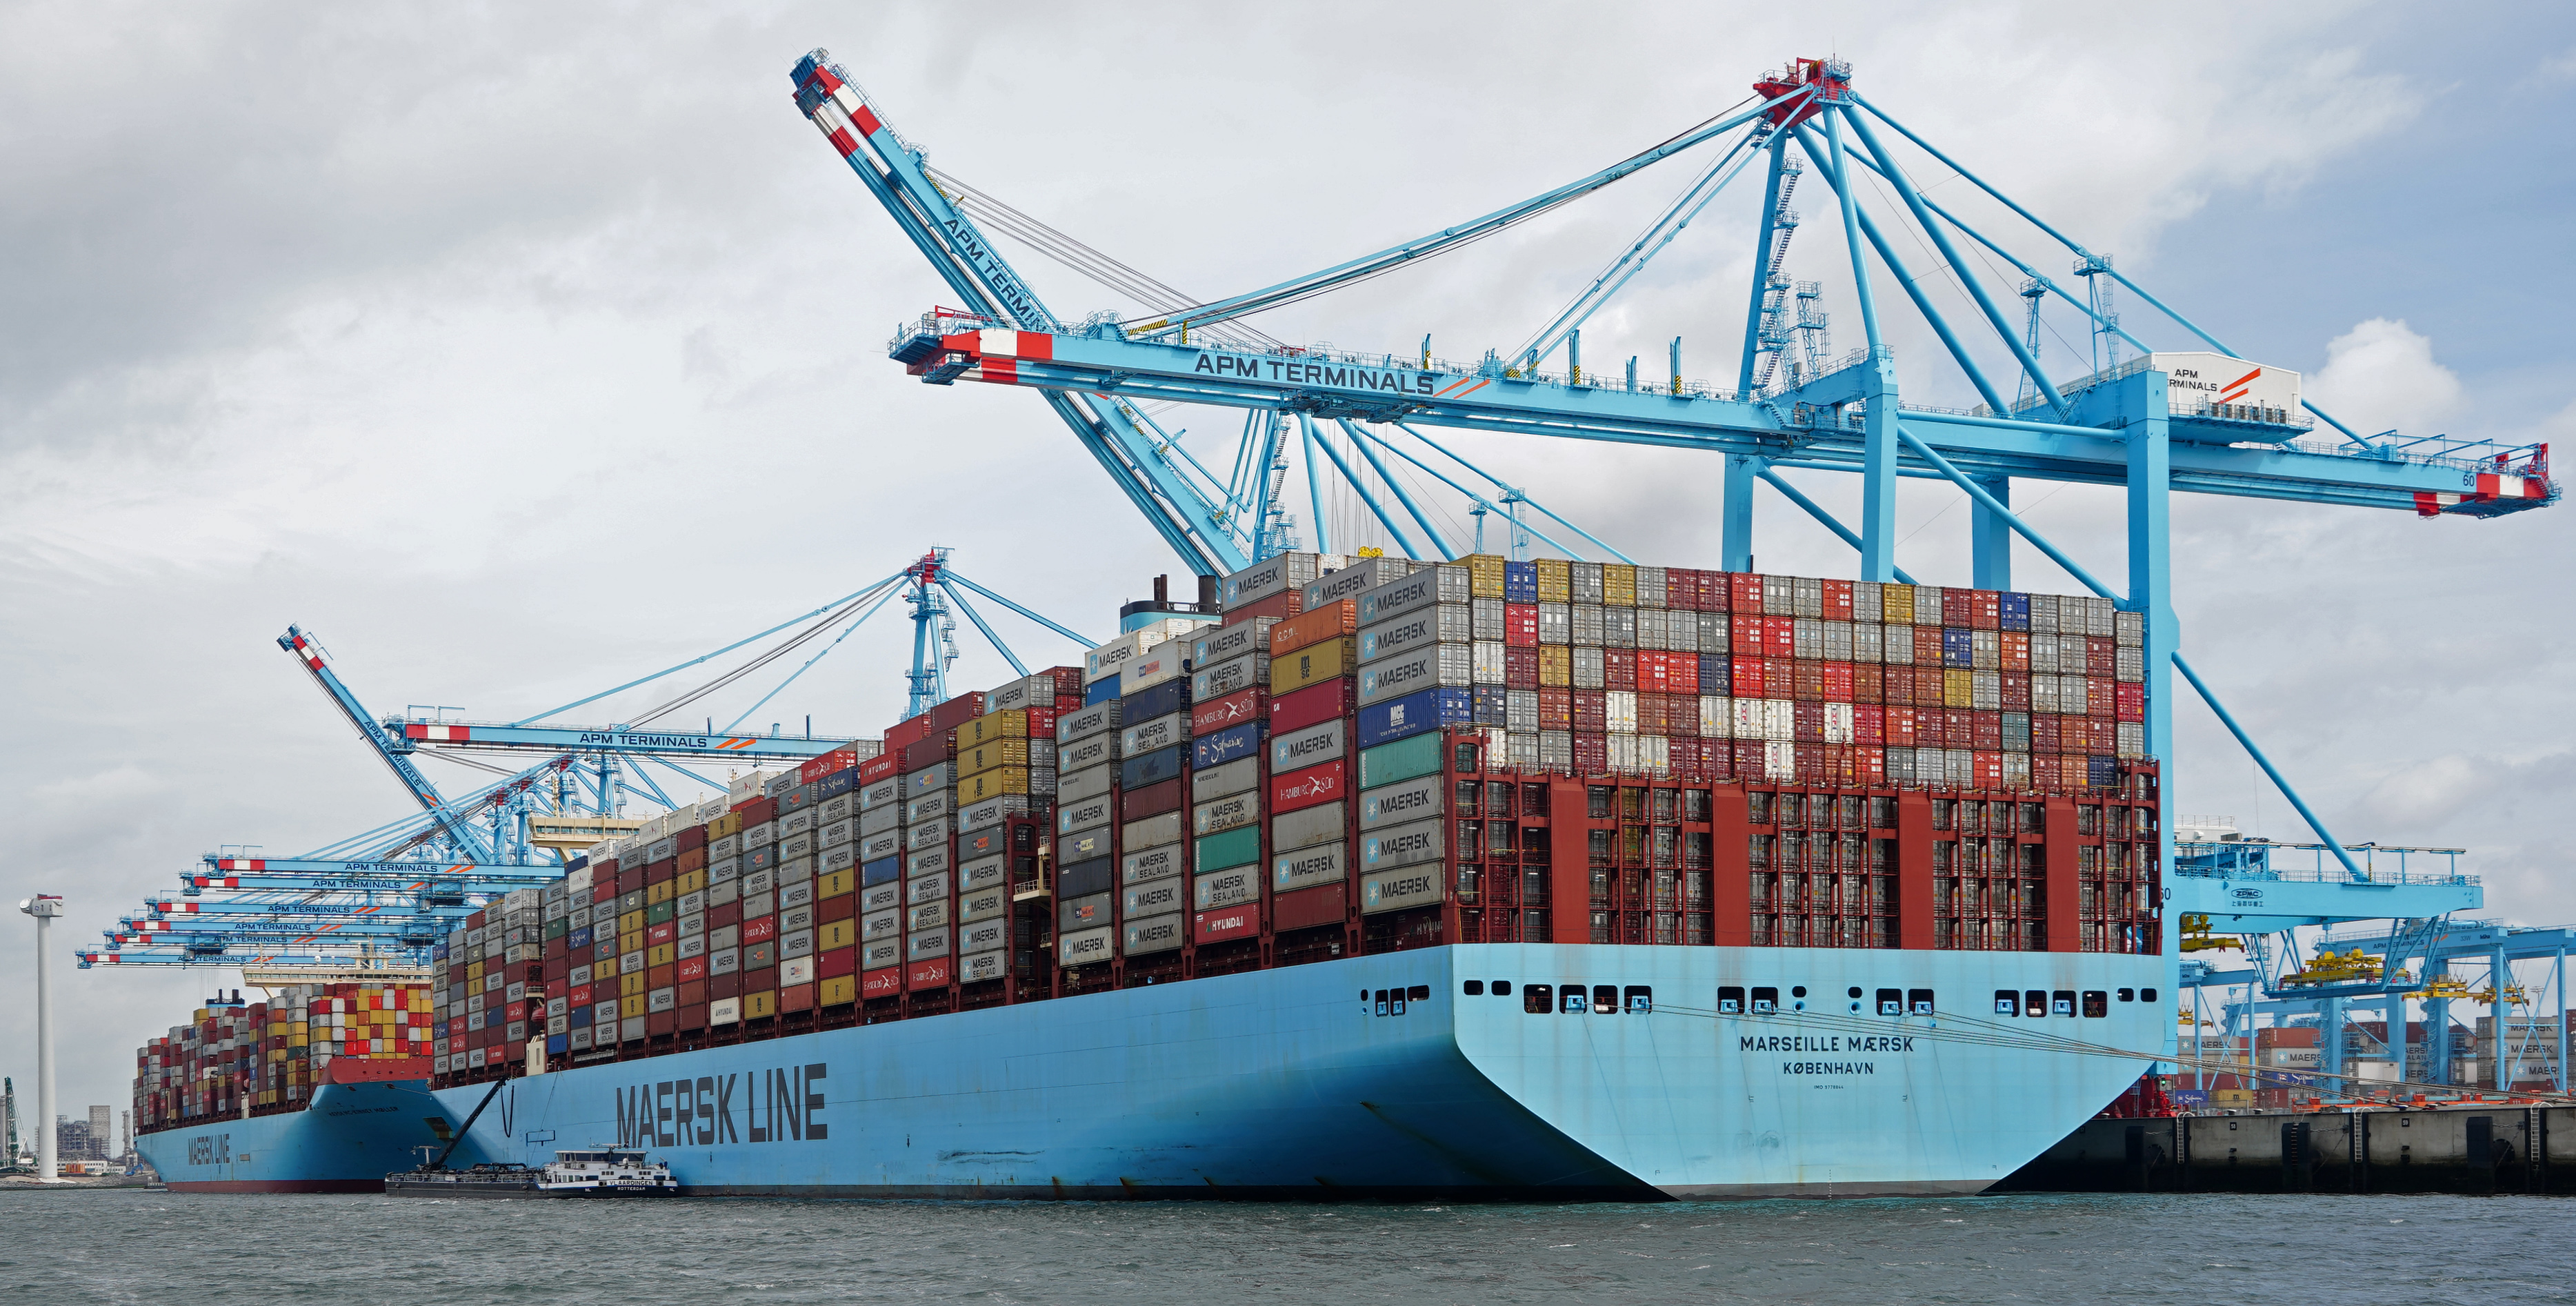

In [8]:
from IPython import display
display.Image("https://upload.wikimedia.org/wikipedia/commons/1/1c/MAERSK_MC_KINNEY_M%C3%96LLER_%26_MARSEILLE_MAERSK_%2848694054418%29.jpg")

In [4]:
# import modules
from pulp import *
from pandas import *

In [11]:
# read csv file
supply_chain = read_csv('supply chain.csv')
supply_chain.head()

,route,demand,capacity_A,cost_A,capacity_B,cost_B,capacity_C,cost_C,capacity_D,cost_D,capacity_E,cost_E
0,1,10,86,1618,53,1704.8,62,1700.0,67,1781.0,53,1726.2
1,2,10,86,1618,56,1460.0,62,1700.0,67,1781.0,91,1792.0
2,3,14,86,1618,105,1685.6,62,1700.0,67,1781.0,105,1964.7
3,4,11,105,1284,53,1116.0,53,1277.6,157,1200.8,53,1446.3
4,5,15,157,1720,105,1632.0,157,1993.6,53,1921.6,105,2469.6


In [12]:
supply_chain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   route       290 non-null    int64  
 1   demand      290 non-null    int64  
 2   capacity_A  290 non-null    int64  
 3   cost_A      290 non-null    int64  
 4   capacity_B  290 non-null    int64  
 5   cost_B      290 non-null    float64
 6   capacity_C  290 non-null    int64  
 7   cost_C      290 non-null    float64
 8   capacity_D  290 non-null    int64  
 9   cost_D      290 non-null    float64
 10  capacity_E  290 non-null    int64  
 11  cost_E      290 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 27.3 KB


### Data Preparation
All variables are put into lists to prepare data for the optimization analysis. Then, cost, capacity, and demand are made into dictionaries.

In [13]:
routes = supply_chain['route'].tolist() 
carriers = ['A', 'B', 'C', 'D', 'E']
demand = supply_chain['demand'].tolist()

# creates costs list of lists
costs = []
costs.append(supply_chain['cost_A'].tolist())
costs.append(supply_chain['cost_B'].tolist())
costs.append(supply_chain['cost_C'].tolist())
costs.append(supply_chain['cost_D'].tolist())
costs.append(supply_chain['cost_E'].tolist())

# creates capacity list of lists
capacity = []
capacity.append(supply_chain['capacity_A'].tolist())
capacity.append(supply_chain['capacity_B'].tolist())
capacity.append(supply_chain['capacity_C'].tolist())
capacity.append(supply_chain['capacity_D'].tolist())
capacity.append(supply_chain['capacity_E'].tolist())

# Creates list of keys
carrier_route = [(c, r) for c in carriers for r in routes]

# Data is made into dictionaries
costs = makeDict([carriers,routes],costs,0)
capacity = makeDict([carriers, routes],capacity,0)
demand = makeDict([routes],demand,0)

### Model Initiation, Decision Variables, and Objective Function
The model variable is created using the LpProblem function. Then, a dictionary called shipments is created that contains LP variables. Finally, the objective function is added to the variable model using a list comprehension.

In [14]:
# Initiates model
model = LpProblem('Supply Chain', LpMinimize)

# Dictionary containing decision variables - numbers of shipments by a given carrier for a given route
shipments = LpVariable.dicts('N', (carriers,routes),0,None,LpInteger)

# Objective function (multiplies shipping cost for each route by a given carrier and sums all of those costs together)
model +=lpSum([shipments[c][r]*costs[c][r] for c in carriers for r in routes])

### Constraints
The retailer needs to transport a set number of containers for each of the 290 routes. Each carrier has a limited container capacity per route of transportation. Also, carriers can charge different prices for their services. Given the high fixed costs of preparing transportation contracts, the retailer would like to work with only those carriers who transport at least a certain number of containers. The retailer prefers to ship at least 500 containers with the B carrier because of the higher quality service.

In [15]:
# Maximimum number of shipments per route by a given carrier can transport
for (c, r) in carrier_route:
    model += shipments[c][r] <= capacity[c][r]
                  
# Number of shipments that are required by the retailer per a given route
for r in demand:
    model +=lpSum([shipments[c][r] for c in carriers]) >= demand[r]

# Overall minimum number of shipments that should be transported by a carrier across routes
for c in carriers:
    model += lpSum([shipments[c][r] for r in routes]) >= 10
    
# Minimum number of shipments that should be transported by the B carrier across routes
model += lpSum([shipments['B'][r] for r in routes]) >= 500

### Solve the Problem
Now that all the problem data is entered, the writeLP() function can be used to copy this information into a .lp file into the directory that your code-block is running from. The LP is solved using the solver that PuLP chooses.

In [16]:
# The problem data is written to an .lp file
model.writeLP('Supply Chain.lp')

# The problem is solved using PuLP's choice of Solver
model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/repl/.local/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/76a10578ebb84ff3ad262fd2bb1be369-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/76a10578ebb84ff3ad262fd2bb1be369-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1751 COLUMNS
At line 10742 RHS
At line 12489 BOUNDS
At line 13940 ENDATA
Problem MODEL has 1746 rows, 1450 columns and 4640 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5.31228e+06 - 0.00 seconds
Cgl0004I processed model has 295 rows, 1450 columns (1450 integer (5 of which binary)) and 2900 elements
Cutoff increment increased from 1e-05 to 0.0999
Cbc0012I Integer solution of 5312280.5 found by greedy cover after 0 iterations and 0 nodes (0.02 seconds)
Cbc0001I Search completed - best objective 5312280.499999995, took 0 i

1

### Results
The results of the solver call can be displayed as output. First, I request the status of the solution, which can be one of “Not Solved,” “Infeasible,” “Unbounded,” “Undefined” or “Optimal.” The optimized objective function value is printed to the screen using the value function. The variables and their resolved optimum values can now be printed. The printed output describes the number of containers that the retailer use with each carrier for a given route to minimize costs under the given constraints.

In [17]:
# The status of the solution is printed 
print('Status:', LpStatus[model.status])

# The optimised objective function value is printed     
print('Total Cost of Transportation = ', value(model.objective))

# Each of the variables is printed with it's resolved optimum value
for v in model.variables():
    print(v.name, '=', v.varValue)

Status: Optimal
Total Cost of Transportation =  5312280.499999995
N_A_1 = 10.0
N_A_10 = 0.0
N_A_100 = 0.0
N_A_101 = 0.0
N_A_102 = 0.0
N_A_103 = 0.0
N_A_104 = 0.0
N_A_105 = 0.0
N_A_106 = 0.0
N_A_107 = 10.0
N_A_108 = 0.0
N_A_109 = 0.0
N_A_11 = 14.0
N_A_110 = 0.0
N_A_111 = 0.0
N_A_112 = 0.0
N_A_113 = 0.0
N_A_114 = 0.0
N_A_115 = 0.0
N_A_116 = 0.0
N_A_117 = 10.0
N_A_118 = 0.0
N_A_119 = 14.0
N_A_12 = 0.0
N_A_120 = 0.0
N_A_121 = 0.0
N_A_122 = 0.0
N_A_123 = 0.0
N_A_124 = 0.0
N_A_125 = 0.0
N_A_126 = 0.0
N_A_127 = 14.0
N_A_128 = 0.0
N_A_129 = 0.0
N_A_13 = 0.0
N_A_130 = 0.0
N_A_131 = 0.0
N_A_132 = 0.0
N_A_133 = 0.0
N_A_134 = 0.0
N_A_135 = 0.0
N_A_136 = 0.0
N_A_137 = 0.0
N_A_138 = 0.0
N_A_139 = 0.0
N_A_14 = 0.0
N_A_140 = 0.0
N_A_141 = 11.0
N_A_142 = 0.0
N_A_143 = 0.0
N_A_144 = 0.0
N_A_145 = 0.0
N_A_146 = 0.0
N_A_147 = 0.0
N_A_148 = 9.0
N_A_149 = 0.0
N_A_15 = 0.0
N_A_150 = 0.0
N_A_151 = 0.0
N_A_152 = 0.0
N_A_153 = 0.0
N_A_154 = 0.0
N_A_155 = 0.0
N_A_156 = 0.0
N_A_157 = 0.0
N_A_158 = 0.0
N_A_159 = 0